## Init

In [45]:
import numpy as np
import polars as pl
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

from abc import ABCMeta, abstractmethod
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
import pandas as pd
import pyarrow as pa
from typing import Callable
import re

from utils.baseclass import Dataset
from utils.data import TitanicDataset
from utils.decorators import PolarsCompatibleTransformer
from utils.transformers import MakeNameFeatures, TransformColToCategorical, TransformStringColToNumeric, TransformColToBins, DropColumns, AddFamilyUnitID, AddSurvivalRate, CleanCabin, FillNull, AddRandomColumn, CleanHonorific, MakeNameFeatures, CleanAge, PipelineCompatibleCatBoostClassifier, CleanFare

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
import xgboost as xgb

from catboost import CatBoostClassifier

In [46]:
DATAPATH = './data'
train = pl.read_csv(f'{DATAPATH}/train.csv')
test = pl.read_csv(f'{DATAPATH}/test.csv')
submission_sample = pl.read_csv(f'{DATAPATH}/gender_submission.csv')

In [47]:
%load_ext autoreload
%autoreload 2

pl.Config.set_tbl_formatting("UTF8_FULL_CONDENSED")
pl.Config.set_tbl_width_chars(175)
pl.Config.set_tbl_cols(99)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# display(train.head())
# display(train_transformed.X.head())

## Data Exploration

In [ ]:
train_explore = train.clone()

In [ ]:
# train_explore.head()
train_explore.describe()

In [ ]:
'''
Name
Ticket
Cabin
'''
(
    train_explore
    .select(
        '*',
        pl.col('Name').str.split(by=', ').apply(lambda x: x[0]).alias('LastName'),
        pl.col('Name').str.split(by=', ').apply(lambda x: x[1]).str.split(by=' ').apply(lambda x: x[0]).alias('Honorific')
    )
)

# train_explore.select('Name', pl.col('Ticket')).sort('Ticket').head(5)

# train_explore.select('Cabin', pl.col('Ticket')).sort('Cabin').head(5)
# train_explore.groupby('Cabin').agg(pl.n_unique('PassengerId').alias('counts')).sort('counts', descending=True)
# train_explore.filter(pl.col('Cabin')=='C23 C25 C27')
# display(train_explore.groupby('Ticket').agg(pl.n_unique('Cabin').alias('cabincount')).filter(pl.col('cabincount') > 1).head(5))
# train_explore.filter(pl.col('Ticket') == '17421')

In [ ]:
def get_features_to_outcome_effect(df: pl.DataFrame, group_cols: list[str], outcome_col: str) -> None:
    for col in group_cols:
        if df[col].dtype in [pl.Float32, pl.Float64]:
            df = (
                df
                .with_columns(pl.col(col).qcut(5).alias(col))
            )
    return df.groupby(group_cols).agg(pl.mean(outcome_col)).sort(group_cols, descending=False)

# single_variable_relation_to_outcome(train_explore, ['Sex'], 'Survived')
# single_variable_relation_to_outcome(train_explore, ['Pclass'], 'Survived')
# single_variable_relation_to_outcome(train_explore, ['Age'], 'Survived')
# single_variable_relation_to_outcome(train_explore, ['SibSp'], 'Survived')
# single_variable_relation_to_outcome(train_explore, ['Parch'], 'Survived')
# single_variable_relation_to_outcome(train_explore, ['Fare'], 'Survived')
# single_variable_relation_to_outcome(train_explore, ['Embarked'], 'Survived')

## Transform data

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import RocCurveDisplay

In [58]:
PIPELINE = Pipeline([
    ('make_name_features', MakeNameFeatures()),
    
    # ('transform_sex', TransformStringColToNumeric('Sex', replace_original=False)),
    # ('transform_embarked', TransformStringColToNumeric('Embarked', replace_original=False)),
    # # ('clean_honorific', CleanHonorific()),
    # ('transform_honorific', TransformStringColToNumeric('Honorific', replace_original=False)),
    # ('transform_age', TransformColToBins('Age', replace_original=False, return_numeric=True)),
    # ('transform_fare', TransformColToBins('Fare', replace_original=False, return_numeric=True)),
    # ('clean_cabin', CleanCabin()),
    # ('transform_cabin', TransformStringColToNumeric('CabinFirstLetter', replace_original=False)),

    ('transform_sex', TransformColToCategorical('Sex', replace_original=False)),
    ('transform_embarked', TransformColToCategorical('Embarked', replace_original=False)),
    ('clean_honorific', CleanHonorific()),
    ('transform_honorific', TransformColToCategorical('Honorific', replace_original=False)),
    
    ('clean_fare', CleanFare()),
    ('transform_fare', TransformColToBins('Fare', replace_original=False, return_numeric=True)),

    ('clean_age', CleanAge()),
    ('transform_age', TransformColToBins('Age', replace_original=False, return_numeric=True)),
    
    ('clean_cabin', CleanCabin()),
    ('transform_cabin', TransformColToCategorical('CabinFirstLetter', replace_original=False)),

    # ('add_familyid_lastname', AddFamilyUnitID(['LastName'])),
    # ('add_survivalrate_lastname', AddSurvivalRate(['LastName'])),
    # ('add_familyid_lastname_ticket', AddFamilyUnitID(['LastName', 'Ticket'])),
    # ('add_survivalrate_lastname_ticket', AddSurvivalRate(['LastName', 'Ticket'])),
    # ('add_familyid_lastname_cabin', AddFamilyUnitID(['LastName', 'Cabin'])),
    # ('add_survivalrate_lastname_cabin', AddSurvivalRate(['LastName', 'Cabin'])),
    
    ('drop_unneeded_cols', DropColumns(
        cols_to_drop=['PassengerId', 'Survived'], # + ['Pclass', 'Age', 'Parch', 'SibSp', 'Fare'],
        regex_to_drop='groupid_*',
        drop_strings = True
    )),

    # ('fill_nulls', FillNull(-1)),
    
    # ('xgbc', XGBClassifier(enable_categorical=True, tree_method='approx'))
    # ('xgbc', XGBClassifier(random_state=123))
    ('catboost', PipelineCompatibleCatBoostClassifier(verbose=False, random_seed=123))
])
train_transformed = TitanicDataset(train.clone(), 'Survived', retain_outcome_col=True, test_size=0.4)
test_transformed = TitanicDataset(test.clone(), 'Survived')

# df_clean = PIPELINE.fit_transform(X=train_transformed.xtrain, y=train_transformed.ytrain)
# df_clean.head(3)
# df_clean.describe(include='all')

2023-08-27 19:00:25.904 | WARNING  | utils.data:__post_init__:27 - Retaining outcome column `Survived` in X. You **must** drop this before training


In [59]:
PIPELINE.fit(X=train_transformed.xtrain, y=train_transformed.ytrain);
# PIPELINE.transform(X=test_transformed.X).head()

/Users/yongjian.tek/.pyenv/versions/3.10.4/envs/kaggle/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2023-08-27 19:00:27.273 | INFO     | utils.transformers:fit:216 - String drop cols: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'LastName', 'Honorific', 'CabinFirstLetter']
2023-08-27 19:00:27.274 | INFO     | utils.transformers:fit:220 - Specified drop cols: ['PassengerId', 'Survived']
2023-08-27 19:00:27.274 | INFO     | utils.transformers:fit:221 - Regex drop cols: []
2023-08-27 19:00:27.275 | INFO     | utils.transformers:fit:222 - String drop cols: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'LastName', 'Honorific', 'CabinFirstLetter']
2023-08-27 19:00:27.276 | INFO     | utils.transformers:fit:223 - Dropping cols: ['CabinFirstLetter', 'Survived', 'Cabin', 'Sex', 'LastName', 'Ticket', 'E

0.8764044943820225
0.8431372549019608


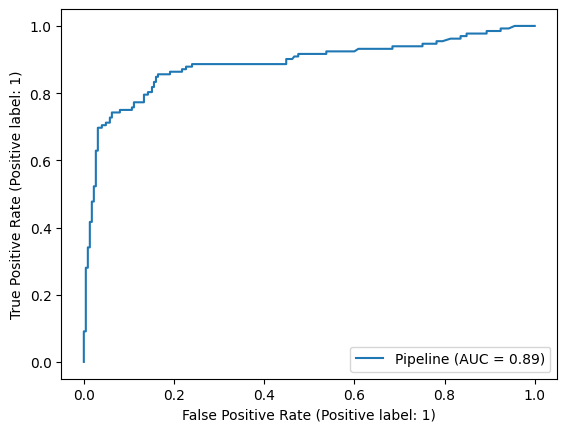

In [73]:
RocCurveDisplay.from_estimator(PIPELINE, train_transformed.xtest, train_transformed.ytest);
print(accuracy_score(train_transformed.ytrain, PIPELINE.predict(train_transformed.xtrain)))
print(accuracy_score(train_transformed.ytest, PIPELINE.predict(train_transformed.xtest)))

In [81]:
manual_preds = (
    pl.from_pandas(test_transformed.X)
    .with_columns(
        pl.Series(PIPELINE.predict(test_transformed.X)).alias('model_preds')
    )
    .with_columns(
        pl.col('Name').str.split(", ").apply(lambda x: x[0]).alias('LastName'),
        pl.col('Name').str.split(", ").apply(lambda x: x[1]).str.split('. ').apply(lambda x: x[0]).alias('Honorific')
    )
    .with_columns(
        pl.when(
            ((pl.col('Sex') == 'female') & (pl.col("Age") <= 18)) | 
            (pl.col('Honorific') == 'Master')
        ).then(
            pl.lit(1)
        ).otherwise(
            # pl.col('model_preds')
            pl.lit(0)
        ).alias('Survived')
    )
)
# manual_preds.head()
# manual_preds.sort('Honorific', 'Sex').head(50)

In [82]:
from datetime import datetime
import os

submission = pl.DataFrame({
    'PassengerId': manual_preds['PassengerId'],
    # 'Survived': PIPELINE.predict(test_transformed.X),
    # 'Survived': np.where(test_transformed.X['Sex'] == 'female', 1, 0)
    'Survived': manual_preds['Survived']
})
filename = f'''./submission/submit_{datetime.now().strftime('%Y%m%d_%H%M')}.csv'''
display(submission.head())
submission.write_csv(filename)
os.system(f'''kaggle competitions submit -c titanic -f {filename} -m {filename}''')

PassengerId,Survived
i64,i32
892,0
893,0
894,0
895,0
896,0


100%|██████████| 2.77k/2.77k [00:03<00:00, 777B/s]


Successfully submitted to Titanic - Machine Learning from Disaster

0

## TODO

In [ ]:
# Basic prediction: Predict men die, women live
# Basic prediction: Women live. Men who are "master" live. All else die

# Remove correlated features?
# Model tuning
# Stacking models
# Ensembling models